In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data/earthquake_data_tsunami.csv')
data.head()

,magnitude,cdi,mmi,sig,nst,dmin,gap,depth,latitude,longitude,Year,Month,tsunami
0,7.0,8,7,768,117,0.509,17.0,14.000,-9.7963,159.596,2022,11,1
1,6.9,4,4,735,99,2.229,34.0,25.000,-4.9559,100.738,2022,11,0
2,7.0,3,3,755,147,3.125,18.0,579.000,-20.0508,-178.346,2022,11,1
3,7.3,5,5,833,149,1.865,21.0,37.000,-19.2918,-172.129,2022,11,1
4,6.6,0,2,670,131,4.998,27.0,624.464,-25.5948,178.278,2022,11,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  782 non-null    float64
 1   cdi        782 non-null    int64  
 2   mmi        782 non-null    int64  
 3   sig        782 non-null    int64  
 4   nst        782 non-null    int64  
 5   dmin       782 non-null    float64
 6   gap        782 non-null    float64
 7   depth      782 non-null    float64
 8   latitude   782 non-null    float64
 9   longitude  782 non-null    float64
 10  Year       782 non-null    int64  
 11  Month      782 non-null    int64  
 12  tsunami    782 non-null    int64  
dtypes: float64(6), int64(7)
memory usage: 79.6 KB


## EDA

### Target Variable Distribution

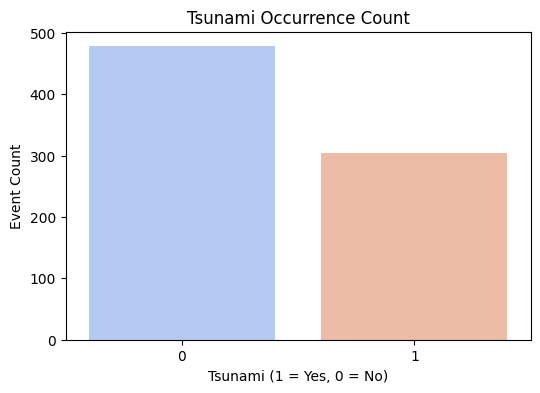

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='tsunami', data=data,  hue='tsunami', palette='coolwarm', legend=False)
plt.title('Tsunami Occurrence Count')
plt.xlabel('Tsunami (1 = Yes, 0 = No)')
plt.ylabel('Event Count')
plt.show()

### Correlation Analysis

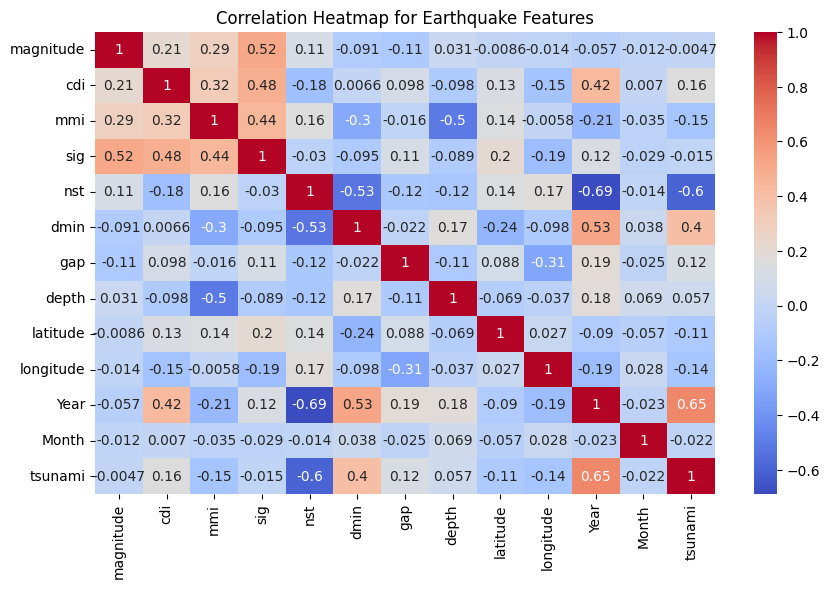

In [9]:
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Earthquake Features')
plt.show()

#### Strong relationships (|r| ≥ 0.5)

nst ↔ Year: r ≈ −0.69 (fewer reporting stations in later years)
tsunami ↔ Year: r ≈ 0.65 (tsunami flag appears more often in recent years; likely dataset bias)
dmin ↔ Year: r ≈ 0.53 (larger station distance in later years)
nst ↔ dmin: r ≈ −0.53 (more stations → smaller minimum distance)
magnitude ↔ sig: r ≈ 0.52 (larger quakes → higher “significance”)
mmi ↔ depth: r ≈ −0.50 (deeper quakes tend to produce lower felt intensity)
Moderate relationships (≈0.3–0.5)

cdi ↔ sig: r ≈ 0.48; mmi ↔ sig: r ≈ 0.44; cdi ↔ mmi: r ≈ 0.32 (felt/modified intensity and significance move together)
tsunami ↔ dmin: r ≈ 0.40; tsunami ↔ nst: r ≈ −0.60 (tsunami events often farther from nearest station and with fewer stations)
gap ↔ longitude: r ≈ −0.31
Near-zero/notable nulls

Magnitude with tsunami: ~0 (magnitude alone doesn’t predict tsunami in this dataset)
Month shows ~0 correlation with most features (little seasonality)
Depth has weak ties to most variables except mmi.
Implications

Multicollinearity: sig, mmi, and cdi are correlated—avoid using all three as independent predictors without regularization/feature selection.
Station-network drift: strong Year links (with nst, dmin, tsunami) suggest dataset/coverage changes. Be cautious using Year as a predictor; it may leak spurious patterns (e.g., more recent instrumentation or reporting practices).
Impact modeling: magnitude + (mmi or cdi) capture much of “significance.” Depth contributes mainly through its negative effect on intensity.
Tsunami prediction: do not rely on magnitude; incorporate geospatial/oceanic context and source mechanism. The Year correlation indicates potential labeling/coverage bias.

### Tsunami Relationships Worth Visualizing

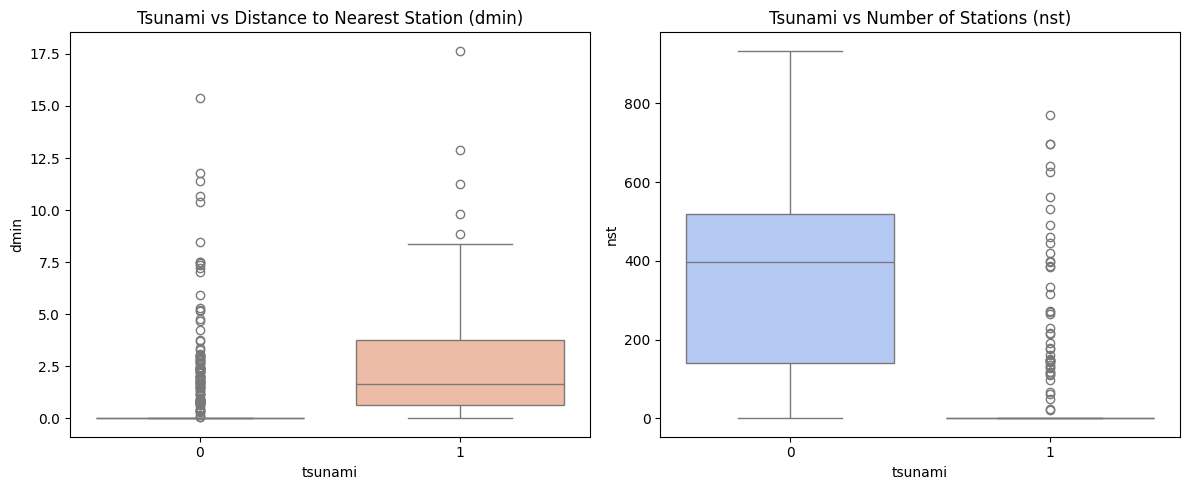

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.boxplot(x='tsunami', y='dmin', data=data, hue='tsunami', palette='coolwarm', legend=False, ax=axes[0])
axes[0].set_title('Tsunami vs Distance to Nearest Station (dmin)')

sns.boxplot(x='tsunami', y='nst', data=data, hue='tsunami', palette='coolwarm', legend=False, ax=axes[1])
axes[1].set_title('Tsunami vs Number of Stations (nst)')

plt.tight_layout()
plt.show()


dmin (distance to nearest station):

Tsunami=1 events have clearly higher medians and a wider spread, with many large outliers.
Interpretation: tsunami‐generating quakes are typically offshore, so the nearest station is farther away.
nst (number of stations):

Tsunami=1 events show markedly lower medians and tighter lower quartiles, with a few high outliers.
Interpretation: offshore events are recorded by fewer stations; also consistent with the negative nst–dmin relationship.
Combined reading:

Tsunami flag is associated with larger dmin and fewer reporting stations. This aligns with the earlier correlations (tsunami ↔ higher dmin; tsunami ↔ lower nst; nst ↔ dmin negative).
There may be confounding from data-collection changes over time and region (e.g., network density), so these features can reflect monitoring coverage, not just physics.

### Temporal & Bias Checks

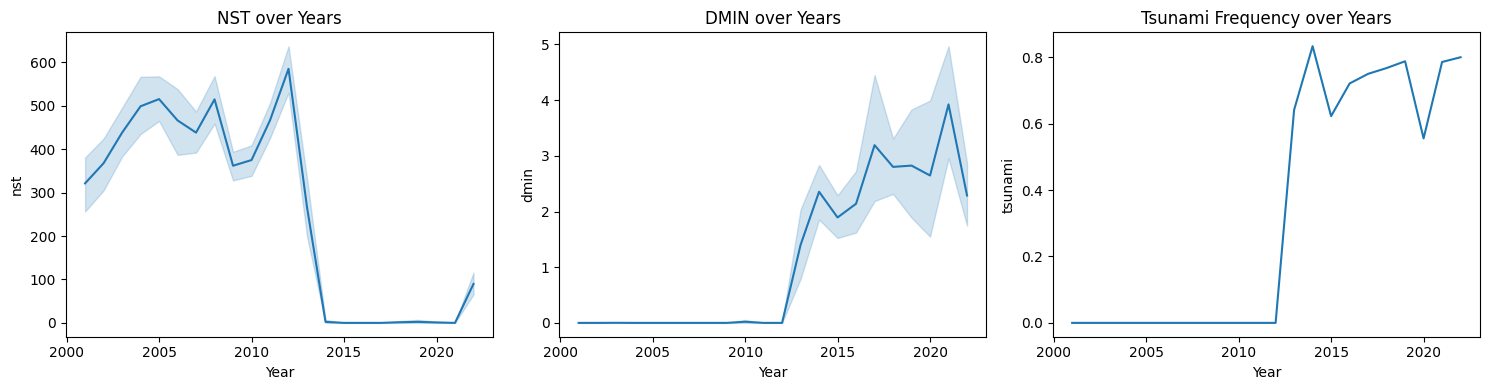

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15,4))

sns.lineplot(x='Year', y='nst', data=data, ax=axes[0])
axes[0].set_title('NST over Years')

sns.lineplot(x='Year', y='dmin', data=data, ax=axes[1])
axes[1].set_title('DMIN over Years')

sns.lineplot(x='Year', y='tsunami', data=data.groupby('Year')['tsunami'].mean().reset_index(), ax=axes[2])
axes[2].set_title('Tsunami Frequency over Years')

plt.tight_layout()
plt.show()

#### Structural break around 2013–2014
- NST (number of stations) drops from 400–600 to near zero, with only a small rebound after 2021.
- DMIN (distance to nearest station) jumps from 0 to 1.5–4+ and stays high.
- Tsunami frequency goes from 0 to consistently high (0.6–0.8) after 2014.

#### Interpretation
- This looks like a data/coverage shift rather than a geophysical change: later years are dominated by offshore events (fewer stations, larger station distance), which also coincide with many tsunami-flagged events.
- Year is therefore strongly confounded with NST, DMIN, and the tsunami label.
- 
#### Implications for modeling/analysis
- High risk of spurious correlations and data leakage if Year (or proxies) are used naively.
- NST and DMIN capture monitoring/network effects and are highly interdependent.

### Depth–Intensity Relationship

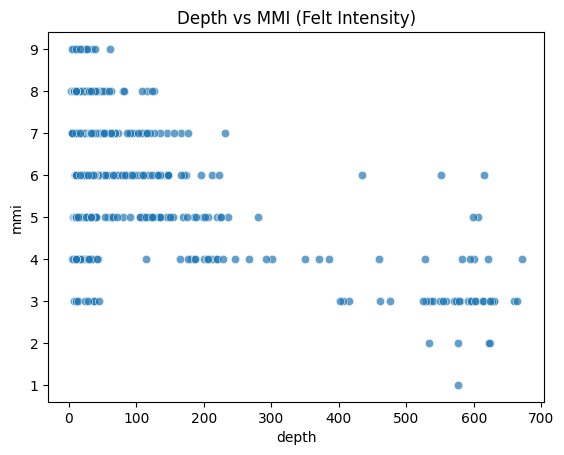

In [16]:
sns.scatterplot(x='depth', y='mmi', data=data, alpha=0.7)
plt.title('Depth vs MMI (Felt Intensity)')
plt.show()

#### Summary
- Clear negative relationship: as depth increases, felt intensity (MMI) decreases.
- High intensities (MMI 7–9) occur almost exclusively at shallow depths (< ~100 km).
- Mid/deep events (> ~300 km) are mostly low intensity (MMI 2–4), with a few higher-intensity outliers likely due to very large - magnitudes.
- Considerable spread at shallow depths indicates other drivers (magnitude, attenuation path, site effects, distance to population) also matter.

#### Implications
- Depth is a strong predictor of shaking felt at the surface; shallow quakes pose greater felt-impact risk.
- Matches the earlier correlation (mmi vs depth ≈ −0.5).

### Magnitude–Significance Relationship

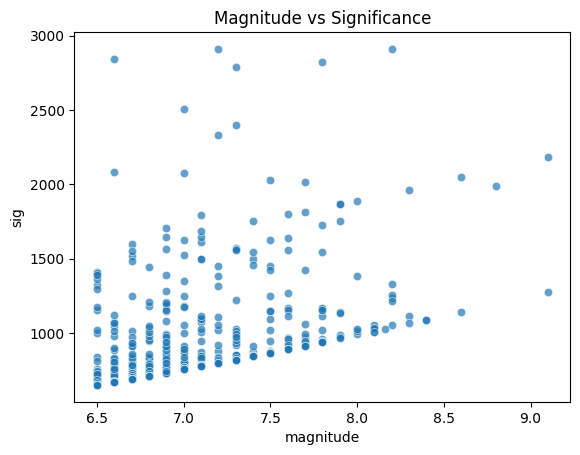

In [17]:
sns.scatterplot(x='magnitude', y='sig', data=data, alpha=0.7)
plt.title('Magnitude vs Significance')
plt.show()

- Clear positive trend: larger magnitudes generally have higher significance. This matches the earlier moderate correlation (~0.5).
- Rising lower envelope: the minimum “sig” increases with magnitude—big events are rarely low‑significance.
- Large spread at all magnitudes: significance varies widely for the same magnitude, indicating strong influence from other factors (felt intensity MMI/CDI, depth, distance to population, location/tsunami).
- High-sig outliers at mid magnitudes (~6.6–7.4) likely reflect shallow, near-population events; conversely, some very large offshore/deep quakes have only moderate “sig.”
- Heteroscedasticity: variance of “sig” increases with magnitude; use robust or quantile regression instead of plain OLS.

### Geospatial Distribution

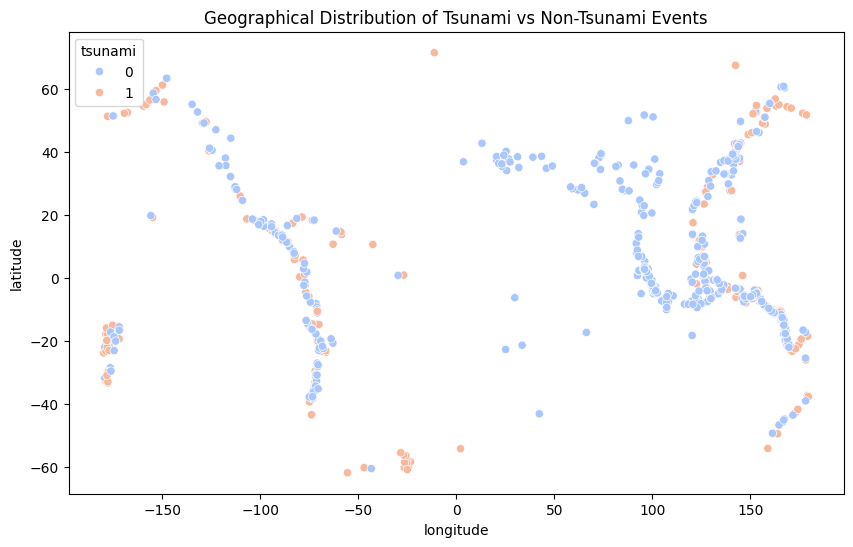

In [20]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='longitude', y='latitude', hue='tsunami', data=data, palette='coolwarm')
plt.title('Geographical Distribution of Tsunami vs Non-Tsunami Events')
plt.show()

- Tsunami events cluster along coastlines and oceanic subduction zones (Pacific “Ring of Fire”: Japan–Kuril, Philippines–Indonesia, Tonga–Kermadec, Alaska–Aleutians, Central/South America, and parts of the SW Pacific). Very few are inland.
- Non‑tsunami events appear both along plate boundaries and farther inland/continental arcs.
- This matches earlier findings: tsunami=1 tends to have larger dmin and fewer stations—offshore locations.
- Regional imbalance: stronger concentration in the NW/SW Pacific; distribution likely influenced by catalog/coverage after ~2014.